### Convolution Neural Network for MNIST Handwritten Digit Recognition
#### **Optimized for CUDA/GPU Training

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

### Check for CUDA availability

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Quadro RTX 4000
Memory: 7.6 GB


### Set random seeds for reproducibility

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

### Data preprocessing with augmentation for better CNN performance

In [26]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Download and load MNIST dataset

In [27]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

### Data loaders with optimal batch size for GPU

In [28]:
batch_size = 128 # Optimal for CNN on RTX 4000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


### Define the Convolutional Neural Network

In [29]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn. Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Second convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Global Average Pooling
        self.global_average_pooling = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Global average pooling
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

### Initialize model and move to GPU

In [30]:
model = ConvNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 276,554


### Print model architecture

In [31]:
print("\nModel Architecture:")
print(model)


Model Architecture:
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (global_average_pooling): Adaptive

### Loss function and optimizer

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### Training function

In [33]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}'
        })

    return running_loss / len(train_loader), 100. * correct / total

### Evaluation function

In [34]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating", leave=False):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return test_loss / len(test_loader), 100. * correct / total

### Training loop

In [35]:
num_epochs = 25
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
start_time = time.time()

best_test_acc = 0.0
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

    # Evaluate
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

    # Update learning rate scheduler
    scheduler.step(test_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save the best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_cnn_mnist_model.pth')
        patience_counter = 0
        print(f"New best model saved! Test Acc: {best_test_acc:.2f}%")
    else:
        patience_counter += 1

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

Starting training...

Epoch [1/25]


Train Loss: 0.7009, Train Acc: 76.50%
Test Loss: 0.1260, Test Acc: 96.26%
LR: 0.001000
New best model saved! Test Acc: 96.26%

Epoch [2/25]


Train Loss: 0.2017, Train Acc: 94.08%
Test Loss: 0.0757, Test Acc: 97.52%
LR: 0.001000
New best model saved! Test Acc: 97.52%

Epoch [3/25]


Train Loss: 0.1508, Train Acc: 95.49%
Test Loss: 0.0560, Test Acc: 98.25%
LR: 0.001000
New best model saved! Test Acc: 98.25%

Epoch [4/25]


Train Loss: 0.1265, Train Acc: 96.28%
Test Loss: 0.0433, Test Acc: 98.57%
LR: 0.001000
New best model saved! Test Acc: 98.57%

Epoch [5/25]


Train Loss: 0.1078, Train Acc: 96.77%
Test Loss: 0.0339, Test Acc: 98.80%
LR: 0.001000
New best model saved! Test Acc: 98.80%

Epoch [6/25]


Train Loss: 0.0947, Train Acc: 97.12%
Test Loss: 0.0399, Test Acc: 98.59%
LR: 0.001000

Epoch [7/25]


Train Loss: 0.0861, Train Acc: 97.45%
Test Loss: 0.0266, Test Acc: 99.11%
LR: 0.001000
New best model saved! Test Acc: 99.11%

Epoch [8/25]


Train Loss: 0.0838, Train Acc: 97.51%
Test Loss: 0.0257, Test Acc: 99.10%
LR: 0.001000

Epoch [9/25]


Train Loss: 0.0780, Train Acc: 97.69%
Test Loss: 0.0237, Test Acc: 99.11%
LR: 0.001000

Epoch [10/25]


Train Loss: 0.0745, Train Acc: 97.78%
Test Loss: 0.0246, Test Acc: 99.13%
LR: 0.001000
New best model saved! Test Acc: 99.13%

Epoch [11/25]


Train Loss: 0.0681, Train Acc: 97.98%
Test Loss: 0.0229, Test Acc: 99.27%
LR: 0.001000
New best model saved! Test Acc: 99.27%

Epoch [12/25]


Train Loss: 0.0691, Train Acc: 98.00%
Test Loss: 0.0316, Test Acc: 98.95%
LR: 0.001000

Epoch [13/25]


Train Loss: 0.0638, Train Acc: 98.14%
Test Loss: 0.0205, Test Acc: 99.37%
LR: 0.001000
New best model saved! Test Acc: 99.37%

Epoch [14/25]


Train Loss: 0.0618, Train Acc: 98.18%
Test Loss: 0.0233, Test Acc: 99.23%
LR: 0.001000

Epoch [15/25]


Train Loss: 0.0608, Train Acc: 98.17%
Test Loss: 0.0227, Test Acc: 99.26%
LR: 0.001000

Epoch [16/25]


Train Loss: 0.0589, Train Acc: 98.27%
Test Loss: 0.0263, Test Acc: 99.09%
LR: 0.001000

Epoch [17/25]


Train Loss: 0.0577, Train Acc: 98.33%
Test Loss: 0.0216, Test Acc: 99.36%
LR: 0.000500

Epoch [18/25]


Train Loss: 0.0441, Train Acc: 98.70%
Test Loss: 0.0227, Test Acc: 99.31%
LR: 0.000500

Epoch [19/25]


Train Loss: 0.0441, Train Acc: 98.69%
Test Loss: 0.0154, Test Acc: 99.50%
LR: 0.000500
New best model saved! Test Acc: 99.50%

Epoch [20/25]


Train Loss: 0.0419, Train Acc: 98.78%
Test Loss: 0.0182, Test Acc: 99.39%
LR: 0.000500

Epoch [21/25]


Train Loss: 0.0413, Train Acc: 98.77%
Test Loss: 0.0146, Test Acc: 99.56%
LR: 0.000500
New best model saved! Test Acc: 99.56%

Epoch [22/25]


Train Loss: 0.0411, Train Acc: 98.76%
Test Loss: 0.0146, Test Acc: 99.46%
LR: 0.000500

Epoch [23/25]


Train Loss: 0.0390, Train Acc: 98.83%
Test Loss: 0.0154, Test Acc: 99.47%
LR: 0.000500

Epoch [24/25]


Train Loss: 0.0405, Train Acc: 98.77%
Test Loss: 0.0159, Test Acc: 99.49%
LR: 0.000500

Epoch [25/25]


Train Loss: 0.0391, Train Acc: 98.81%
Test Loss: 0.0157, Test Acc: 99.50%
LR: 0.000250

Training completed in 380.24 seconds


### Plot training history

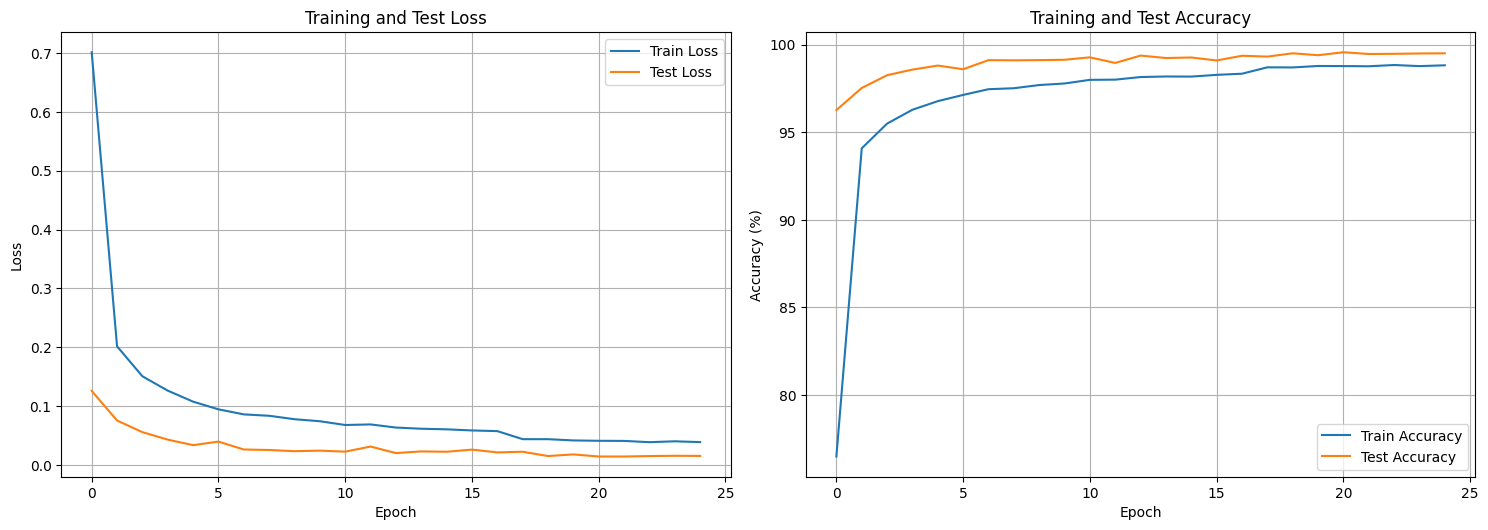

In [36]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Feature visualization - show some filters from first conv layer

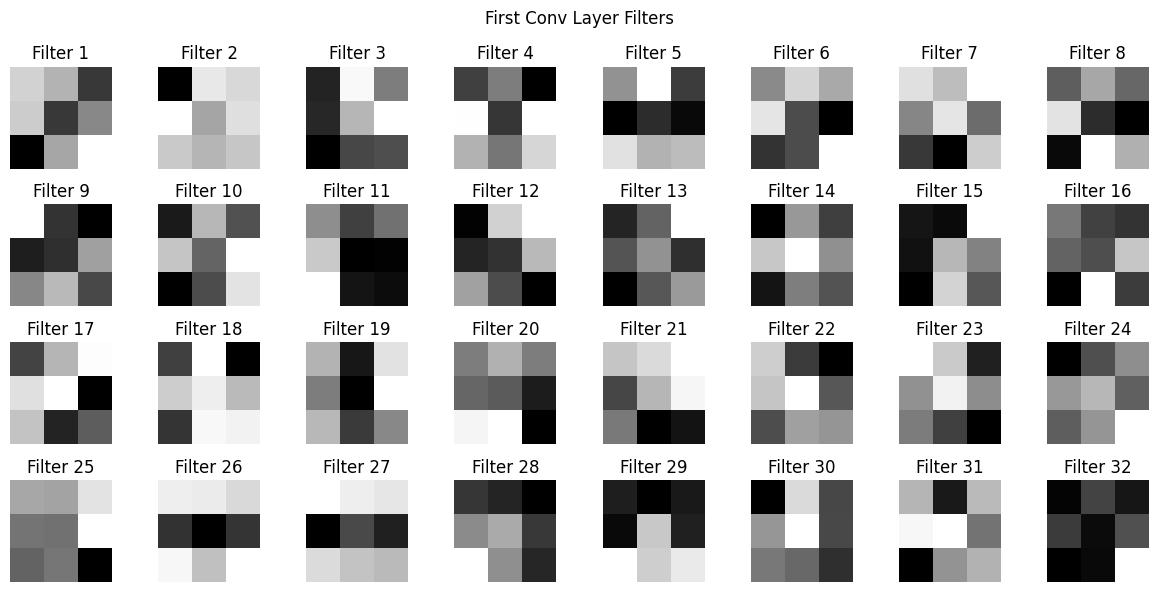

In [37]:
conv1_weights = model.conv1.weight.data.cpu()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i in range(32):
    ax = axes[i//8, i%8]
    ax.imshow(conv1_weights[i, 0], cmap='gray')
    ax.set_title(f'Filter {i+1}')
    ax.axis('off')
fig.suptitle('First Conv Layer Filters')
fig.tight_layout()
plt.show()

### Display some test images iwth predictions

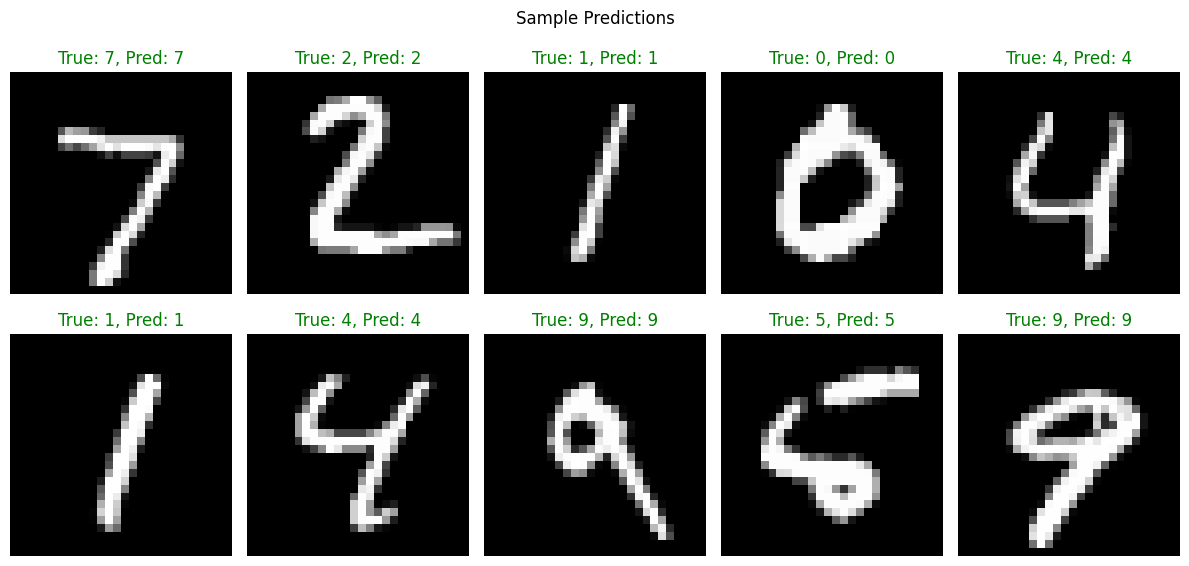

In [38]:
model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, predicted = torch.max(output, 1)

# Show first 10 images
fig_pred, axes_pred = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes_pred[i//5, i%5]
    img = data[i].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    color = 'green' if predicted[i] == target[i] else 'red'
    ax.set_title(f'True: {target[i].item()}, Pred: {predicted[i].item()}', color=color)
    ax.axis('off')
fig_pred.suptitle('Sample Predictions')
fig_pred.tight_layout()
plt.show()

### Feature map visualization

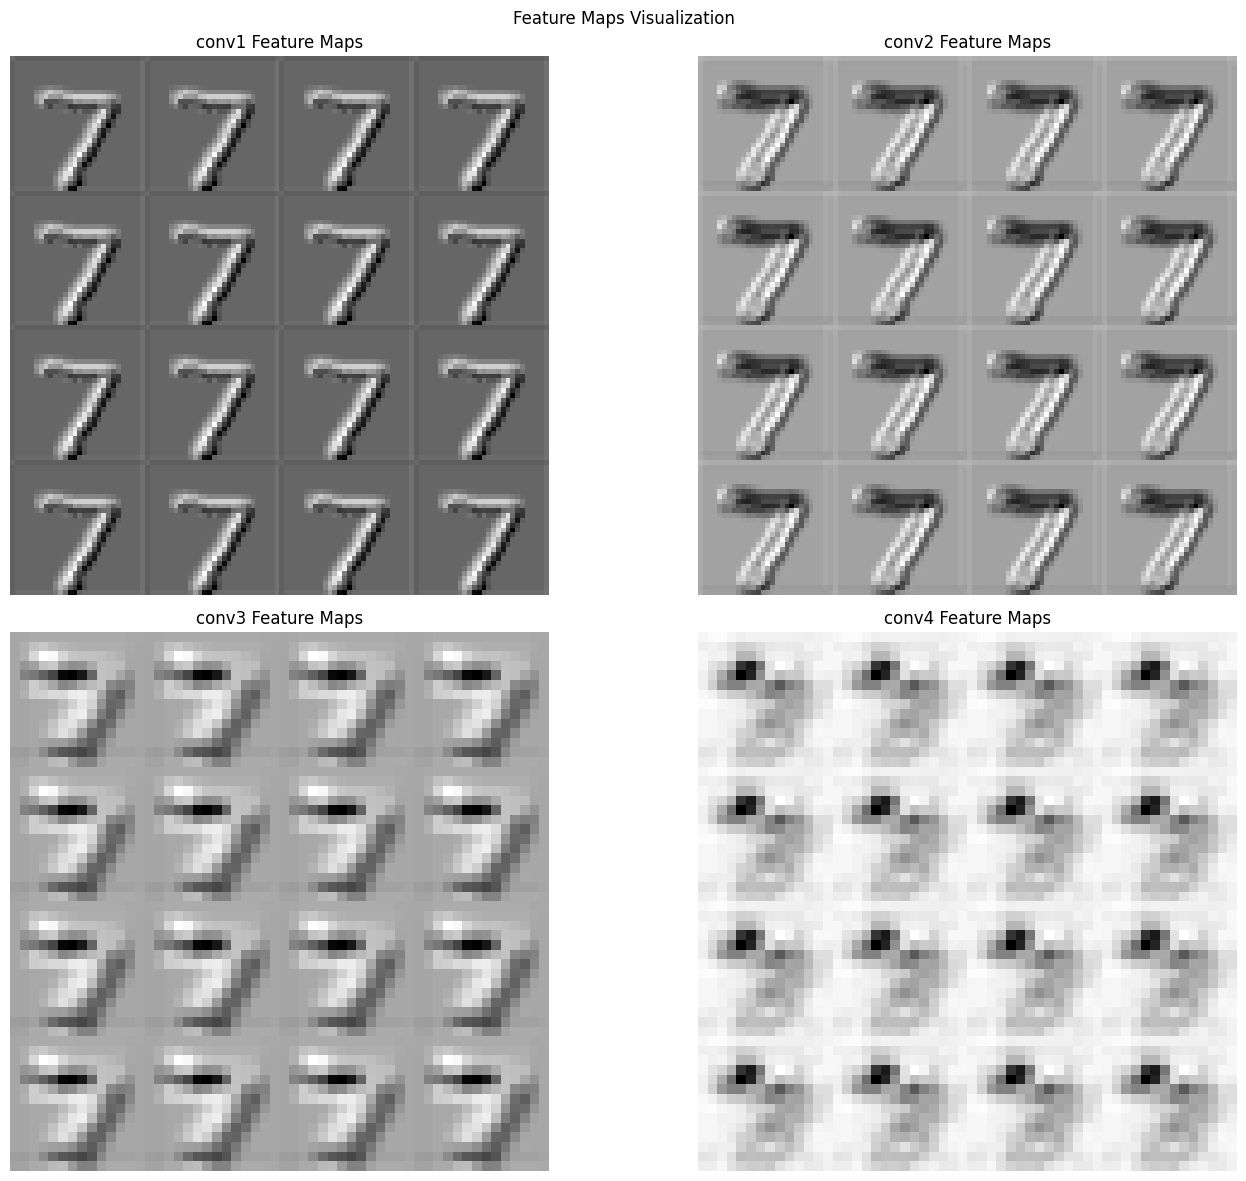

In [39]:
def visualize_feature_maps(model, data_loader, device):
    model.eval()

    # Get a batch of data
    data, _ = next(iter(data_loader))
    data = data.to(device)

    # Hook to capture intermediate outputs
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hooks
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.conv2.register_forward_hook(get_activation('conv2'))
    model.conv3.register_forward_hook(get_activation('conv3'))
    model.conv4.register_forward_hook(get_activation('conv4'))

    # Forward pass
    with torch.no_grad():
        _ = model(data)

    # Visualize feature maps
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    layers = ['conv1', 'conv2', 'conv3', 'conv4']
    for idx, layer in enumerate(layers):
        ax = axes[idx//2, idx%2]

        # Get feature maps for first image
        feature_maps = activation[layer][0].cpu().numpy()

        # Display first 16 feature maps
        feature_grid = np.zeros((4*feature_maps.shape[1], 4*feature_maps.shape[2]))
        for i in range(min(16, feature_maps.shape[0])):
            row = i // 4
            col = i % 4
            feature_grid[row*feature_maps.shape[1]:(row+1)*feature_maps.shape[1],
                         col*feature_maps.shape[2]:(col+1)*feature_maps.shape[2]] = feature_maps[1]
        
        ax.imshow(feature_grid, cmap='gray')
        ax.set_title(f'{layer} Feature Maps')
        ax.axis('off')
    
    plt.suptitle('Feature Maps Visualization')
    plt.tight_layout()
    plt.show()

# Visualize feature maps
visualize_feature_maps(model, test_loader, device)

### Final evaluation with confusion matrix

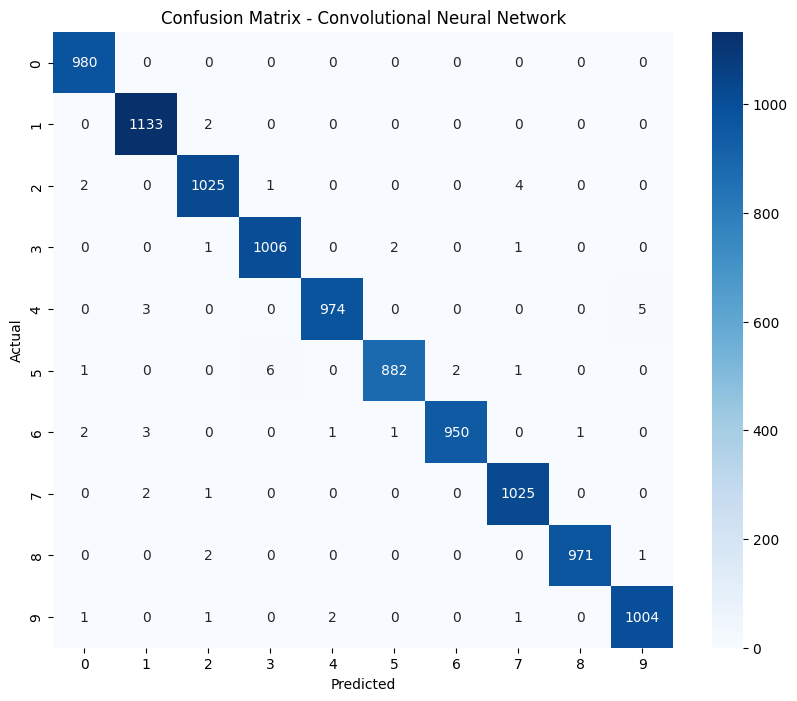


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      1.00      0.99      1009

    accuracy                           0.99     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      0.99      0.99     10000



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get all predictions for confusion matrix
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Convolutional Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Classfication report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=[str(i) for i in range(10)]))

### Performance comparison function

In [41]:
def analyze_model_performance():
    # Per-class accuracy
    class_correct = np.zeros(10)
    class_total = np.zeros(10)

    for i in range(len(all_targets)):
        label = all_targets[i]
        class_total[label] += 1
        if all_predictions[i] == label:
            class_correct[label] += 1
    
    print("\nPer-class Accuracy:")
    for i in range(10):
        acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Digit {i}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
    
analyze_model_performance()

# Save the final model
torch.save(model.state_dict(), 'cnn_mnist_model.pth')
print("\nModel saved as 'cnn_mnist_model.pth'")
print("Best model saved as 'best_cnn_mnist_model.pth'")

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"\nBest Test Accuracy: {max(test_accuracies):.2f}%")

# Model comparison summary
print("\n" + "="*50)
print("MODEL PERFOMANCE SUMMARY")
print("="*50)
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print("="*50)


Per-class Accuracy:
Digit 0: 100.00% (980/980)
Digit 1: 99.82% (1133/1135)
Digit 2: 99.32% (1025/1032)
Digit 3: 99.60% (1006/1010)
Digit 4: 99.19% (974/982)
Digit 5: 98.88% (882/892)
Digit 6: 99.16% (950/958)
Digit 7: 99.71% (1025/1028)
Digit 8: 99.69% (971/974)
Digit 9: 99.50% (1004/1009)

Model saved as 'cnn_mnist_model.pth'
Best model saved as 'best_cnn_mnist_model.pth'

Final Test Accuracy: 99.50%

Best Test Accuracy: 99.56%

MODEL PERFOMANCE SUMMARY
Total Parameters: 276,554
Training Time: 380.24 seconds
Best Test Accuracy: 99.56%
Final Test Accuracy: 99.50%
